In [1]:
!pip install keras cython h5py --quiet

In [2]:
import pandas as pd
import numpy as np

In [3]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import zipfile

In [5]:
with zipfile.ZipFile('data/training.zip') as zip:
    with zip.open('training.csv') as myZip:
        df = pd.read_csv(myZip)

In [8]:
# with zipfile.ZipFile('data/test.zip') as zip:
#     with zip.open('test.csv') as myZip:
#         df_test = pd.read_csv(myZip)

In [6]:
from scipy.misc import imrotate

In [7]:
def rotate_image(image, angle):
    
    rotated_image_str = ' '.join(
        [str(n) for n in imrotate(np.fromstring(image['Image'], sep=' ').reshape(96, 96), -angle).reshape(96*96,)]
    )
    
    angle_rad = np.radians(angle)
    cos = np.cos(angle_rad)
    sin = np.sin(angle_rad)
    
    keypoints = image.drop('Image').values - 48
    rotated_keypoints = np.zeros(30)
    
    for i in range(15):
        rotated_keypoints[2*i] = cos*keypoints[2*i] - sin*keypoints[2*i+1]
        rotated_keypoints[2*i+1] = sin*keypoints[2*i] + cos*keypoints[2*i+1]
    
    rotated_image_keypoints = image.drop('Image')
    rotated_image_keypoints.iloc[:] = rotated_keypoints + 48
    rotated_image_keypoints['Image'] = rotated_image_str
    
    return rotated_image_keypoints

In [8]:
def rotate_images(image_df, angle):
    
    rotated_image_series = image_df['Image'].map(
        lambda image: ' '.join(
            [str(n) for n in imrotate(np.fromstring(image, sep=' ').reshape(96, 96), -angle).reshape(96*96,)]
        )
    )
    
    angle_rad = np.radians(angle)
    cos = np.cos(angle_rad)
    sin = np.sin(angle_rad)
    
    keypoints_matrix = image_df.drop('Image', axis=1).values - 48
    rotated_keypoints = np.zeros_like(keypoints_matrix)

    for i in range(15):
        rotated_keypoints[:, 2*i] = cos*keypoints_matrix[:, 2*i] - sin*keypoints_matrix[:, 2*i+1]
        rotated_keypoints[:, 2*i+1] = sin*keypoints_matrix[:, 2*i] + cos*keypoints_matrix[:, 2*i+1]
    
    rotated_images_df = pd.DataFrame(rotated_keypoints+48, columns=image_df.drop('Image', axis=1).columns)
    rotated_images_df['Image'] = rotated_image_series
        
    return rotated_images_df

In [7]:
teta = 5

In [8]:
%%time
rotated_cw_5 = rotate_images(df, 5)

CPU times: user 1min 55s, sys: 650 ms, total: 1min 55s
Wall time: 1min 55s


In [9]:
%%time
rotated_ccw_5 = rotate_images(df, -5)

CPU times: user 1min 54s, sys: 830 ms, total: 1min 55s
Wall time: 1min 55s


In [10]:
# %%time
# rotated_images_list = [rotate_image(df.iloc[i, :], teta) for i in range(len(df))]
# df2 = pd.DataFrame(rotated_images_list, columns=df.columns)

In [11]:
# a = rotate_image(df.iloc[3000, :], 5)

In [12]:
# for k in range(15):
#     plt.plot(a.iloc[2*k], a.iloc[2*k+1], c='r', marker='o')
#     plt.imshow(np.fromstring(a['Image'], sep=' ').reshape(96, 96), cmap='gray')

In [13]:
# for k in range(15):
#     plt.plot(df.iloc[3000, 2*k], df.iloc[3000, 2*k+1], c='r', marker='o')
#     plt.imshow(np.fromstring(df.loc[3000, 'Image'], sep=' ').reshape(96, 96), cmap='gray')

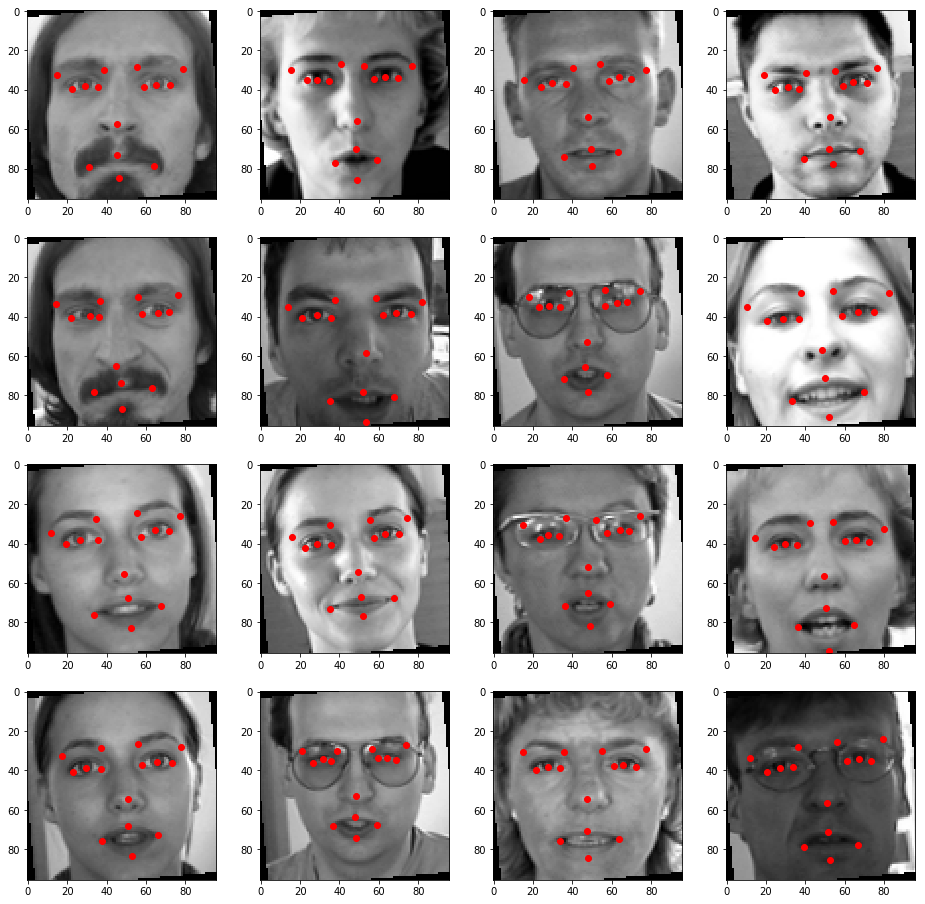

In [16]:
f, ax = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        for k in range(15):
            ax[i, j].plot(rotated_ccw_5.iloc[i*4 + j, 2*k], rotated_ccw_5.iloc[i*4 + j, 2*k+1], c='r', marker='o')
        ax[i, j].imshow(np.fromstring(rotated_ccw_5.loc[i*4 + j, 'Image'], sep=' ').reshape(96, 96), cmap='gray')

In [17]:
# for k in range(15):
#     if 'right' in cols[2*k]:
#         plt.plot(df.iloc[0, 2*k], df.iloc[0, 2*k+1], c='r', marker='o')
# plt.imshow(np.fromstring(df.loc[0, 'Image'], sep=' ').reshape(96 ,96), cmap='gray')

In [18]:
# a = np.fliplr(np.fromstring(df.loc[0, 'Image'], sep=' ').reshape(96, 96))

In [19]:
# for k in range(15):
#     plt.plot(96 - df.iloc[0, 2*k], df.iloc[0, 2*k+1], c='r', marker='o')
# plt.imshow(a, cmap='gray')

In [9]:
def flip_images(image_df):
    
    flipped_image_series = image_df['Image'].map(
        lambda image: ' '.join(
            [str(n) for n in np.fliplr(np.fromstring(image, sep=' ').reshape(96, 96)).reshape(96*96,)]
        )
    )
    
    flipped_image_df = image_df.drop('Image', axis=1)
    for i in range(15):
        flipped_image_df.iloc[:, 2*i] = 96 - flipped_image_df.iloc[:, 2*i]
        
    colname_list = [colname.replace('right', 'TEMP') for colname in flipped_image_df.columns.tolist()]
    colname_list = [colname.replace('left', 'right') for colname in colname_list]
    colname_list = [colname.replace('TEMP', 'left') for colname in colname_list]
    
    flipped_image_df.columns = colname_list
    flipped_image_df = flipped_image_df[image_df.drop('Image', axis=1).columns.tolist()]
    flipped_image_df['Image'] = flipped_image_series
    
    return flipped_image_df

In [21]:
%%time
flipped_df = flip_images(df)

CPU times: user 53.7 s, sys: 540 ms, total: 54.2 s
Wall time: 54.2 s


In [22]:
# for k in range(15):
#     if 'right' in cols[2*k]:
#         plt.plot(flipped_df.iloc[0, 2*k], flipped_df.iloc[0, 2*k+1], c='r', marker='o')
# plt.imshow(np.fromstring(flipped_df.loc[0, 'Image'], sep=' ').reshape(96 ,96), cmap='gray')

In [23]:
df.loc[:, ['nose_tip_x', 'nose_tip_y',
           'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
           'left_eye_center_x', 'left_eye_center_y',
           'right_eye_center_x', 'right_eye_center_y']
      ].dropna().shape

(7000, 8)

In [24]:
mixed_data = pd.concat([df, rotated_cw_5, rotated_ccw_5, flipped_df])
mixed_data.shape

(28196, 31)

In [10]:
from sklearn.utils import shuffle

In [26]:
mixed_data = shuffle(mixed_data).reset_index(drop=True)

In [27]:
all_keypoints = mixed_data.dropna()
all_keypoints.shape

(8560, 31)

In [28]:
four_keypoints = mixed_data.loc[:, ['nose_tip_x', 'nose_tip_y',
                                    'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                                    'left_eye_center_x', 'left_eye_center_y',
                                    'right_eye_center_x', 'right_eye_center_y',
                                    'Image']
                               ].dropna()

four_keypoints.shape

(28000, 9)

In [29]:
all_keypoints.to_pickle('all_keypoints.data')
four_keypoints.to_pickle('four_keypoints.data')

In [11]:
def adjust_contrast(image_df, degree=.8):
    
    image_list = [np.fromstring(image, sep=' ') for image in image_df['Image']]
    adjusted_contrast_images = pd.Series([degree*image + (1-degree)*image.mean() for image in image_list])
    adjusted_image_str_list = adjusted_contrast_images.map(lambda image: ' '.join([str(round(n)) for n in image]))
    
    adjusted_contrast_df = image_df.drop('Image', axis=1)
    adjusted_contrast_df['Image'] = adjusted_image_str_list
    
    return adjusted_contrast_df

In [96]:
%%time
adjusted_contrast_df = adjust_contrast(df)

CPU times: user 44.8 s, sys: 0 ns, total: 44.8 s
Wall time: 44.9 s


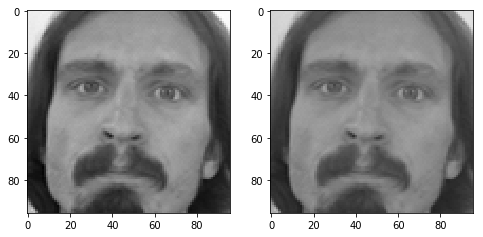

In [100]:
f, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(np.fromstring(df.loc[0, 'Image'], sep=' ').reshape(96, 96), cmap='gray', vmin=0, vmax=255)
ax[1].imshow(np.fromstring(adjusted_contrast_df.loc[0, 'Image'], sep=' ').reshape(96, 96), cmap='gray', vmin=0, vmax=255)

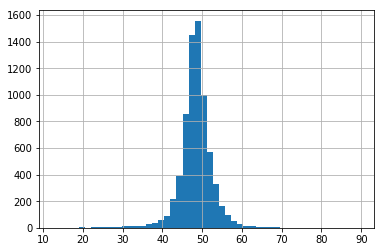

In [105]:
df.nose_tip_x.hist(bins=50)

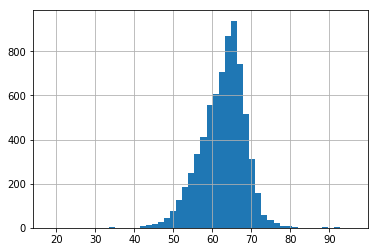

In [106]:
df.nose_tip_y.hist(bins=50)

In [26]:
nose_x_mask = (df['nose_tip_x'] > 38) & (df['nose_tip_x'] < 60)

In [27]:
nose_y_mask = (df['nose_tip_y'] > 45) & (df['nose_tip_y'] < 76)

In [28]:
df2 = df[~(nose_x_mask & nose_y_mask)].reset_index(drop=True)

In [29]:
df2.shape

(252, 31)

In [30]:
df_cw_5 = rotate_images(df2, 5)

In [31]:
df_cw_15 = rotate_images(df2, 15)

In [32]:
df_ccw_10 = rotate_images(df2, -10)

In [33]:
df_ccw_20 = rotate_images(df2, -20)

In [34]:
mixed1 = pd.concat([df2, df_cw_5, df_ccw_10, df_cw_15, df_ccw_20]).reset_index(drop=True)

In [35]:
mixed1.shape

(1260, 31)

In [36]:
df_flipped = flip_images(mixed1)

In [37]:
mixed2 = pd.concat([mixed1, df_flipped]).reset_index(drop=True)

In [38]:
df_cont = adjust_contrast(mixed2)

In [39]:
mixed3 = pd.concat([mixed2, df_cont]).reset_index(drop=True)

In [47]:
four_keypoints_3 = mixed3.loc[:, ['nose_tip_x', 'nose_tip_y',
                                  'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                                  'left_eye_center_x', 'left_eye_center_y',
                                  'right_eye_center_x', 'right_eye_center_y',
                                  'Image']
                             ].dropna()

four_keypoints_3.shape

(4600, 9)

In [48]:
four_keypoints_3 = shuffle(four_keypoints_3).reset_index(drop=True)

In [50]:
four_keypoints_3.to_pickle('four_keypoints_3.data')